In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm, trange
import yaml
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model import CNN_Transformer
from dataset import load_NASA, BatteryDataset

# Load the YAML configuration file
with open('config.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

# # Access the variables
NUM_CYCLES = cfg['NUM_CYCLES']
FEATURE_DIM = cfg['FEATURE_DIM']
EPOCHS = cfg['EPOCHS']
LEARNING_RATE = cfg['LEARNING_RATE']
BATCH_SIZE = cfg['BATCH_SIZE']

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
battery_dict = load_NASA(folder='NASA_DATA', scale_data=True)
battery_dict_no18 = {key: val for key, val in battery_dict.items() if key != 'B0018'}
dataset = BatteryDataset(battery_dict_no18, num_cycles=NUM_CYCLES)

# Train/test split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# NN model
model = CNN_Transformer(feature_dim=FEATURE_DIM, num_cycles=NUM_CYCLES).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
best_loss = float('inf')
model.train()

t_range = trange(EPOCHS)
for epoch in t_range:
    train_losses = []
    for inputs, outputs in train_dataloader:
        inputs = inputs.float().to(device)
        outputs = outputs.float().to(device)
        predicted_outputs = model(inputs, outputs[:,:-1])

        optimizer.zero_grad()
        loss = criterion(predicted_outputs, outputs[:,-1].unsqueeze(-1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    test_losses = []
    for inputs, outputs in test_dataloader:
        inputs = inputs.float().to(device)
        outputs = outputs.float().to(device)
        with torch.no_grad():
            predicted_outputs = model(inputs, outputs[:,:-1])
            test_loss = criterion(predicted_outputs, outputs[:,-1].unsqueeze(-1))
            test_losses.append(test_loss.item())

    # Print the loss for monitoring after each epoch
    t_range.set_description(f"train loss: {np.mean(train_losses)}, test loss: {np.mean(test_losses)}")
    t_range.refresh()

    # Check if the current loss is the best so far
    if np.mean(test_losses) < best_loss:
        best_loss = np.mean(test_losses)
        torch.save(model, 'trained_model.pt')

train loss: 4.866349745498155e-05, test loss: 0.00020985587034374475: 100%|██████████| 2000/2000 [06:10<00:00,  5.40it/s]


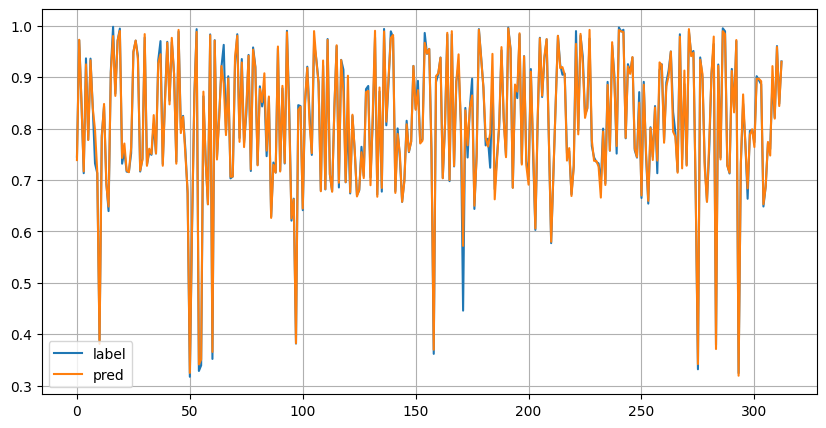

In [ ]:
soh_labels = []
soh_preds = []
for inputs, outputs in test_dataloader:
    inputs = inputs.float().to(device)
    outputs = outputs.float().to(device)
    with torch.no_grad():
        predicted_outputs = model(inputs, outputs[:,:-1])
        soh_labels.append(outputs[:,-1].cpu().numpy().ravel())
        soh_preds.append(predicted_outputs.cpu().numpy().ravel())

soh_labels = np.hstack(soh_labels)
soh_preds = np.hstack(soh_preds)

plt.figure(figsize=(10,5))
plt.plot(soh_labels)
plt.plot(soh_preds)
plt.grid()
plt.legend(['label','pred'])

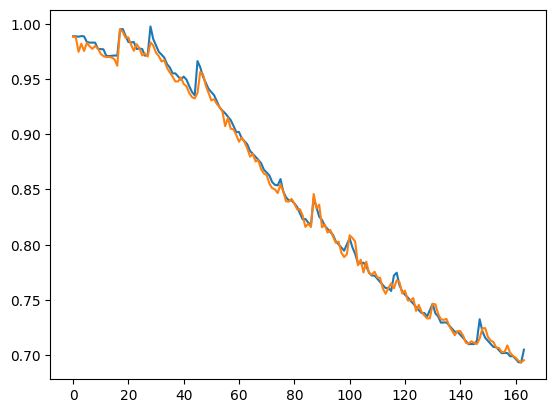

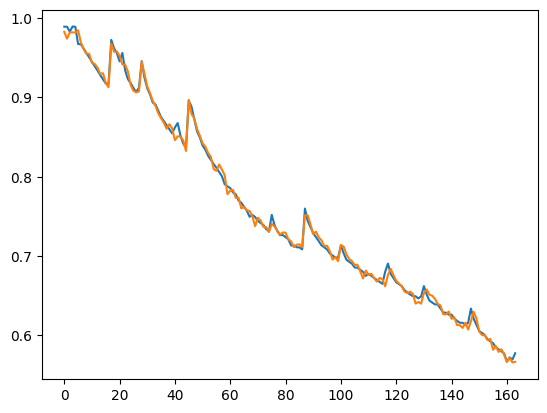

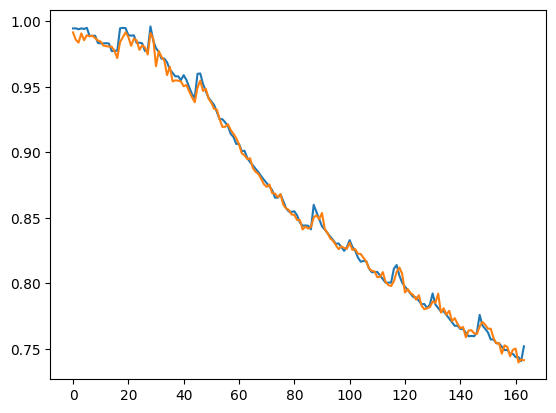

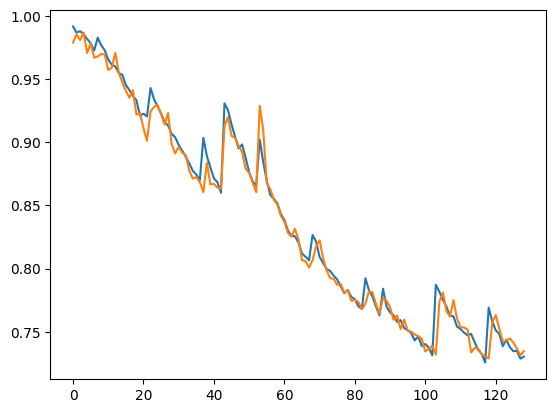

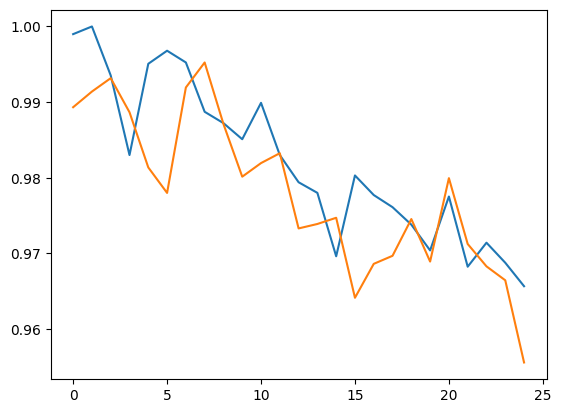

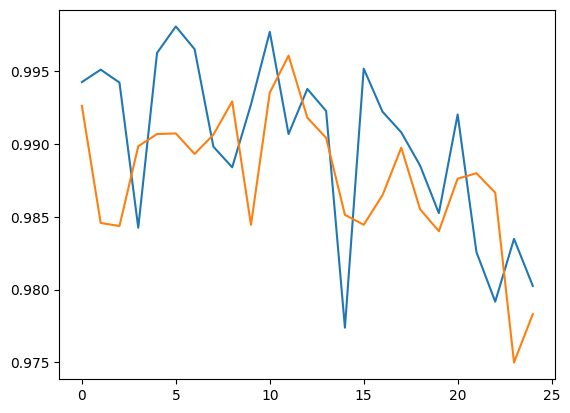

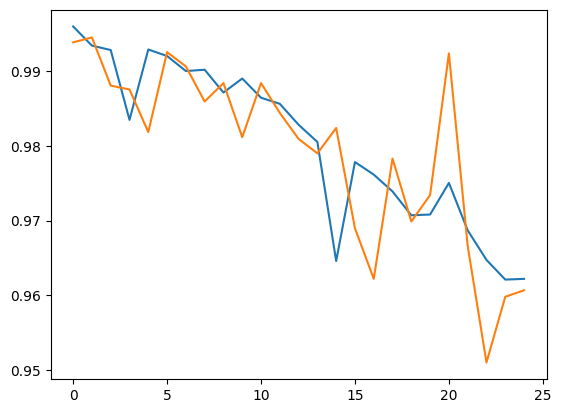

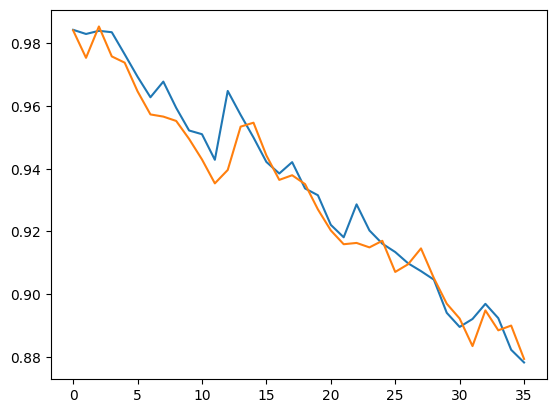

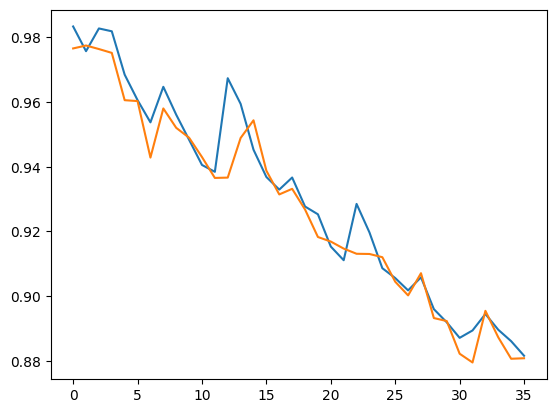

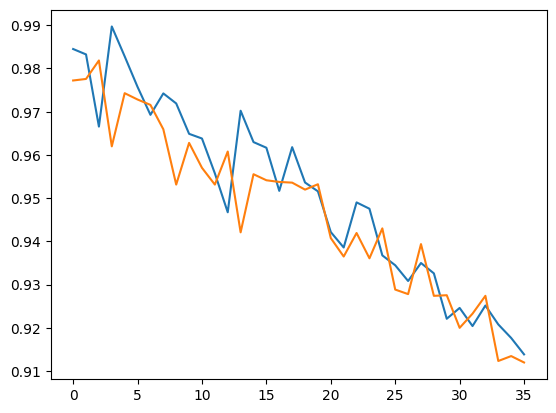

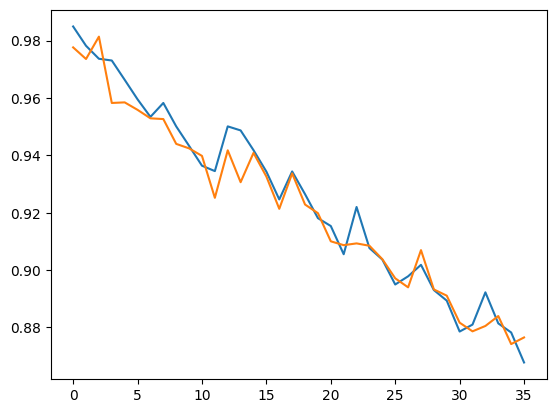

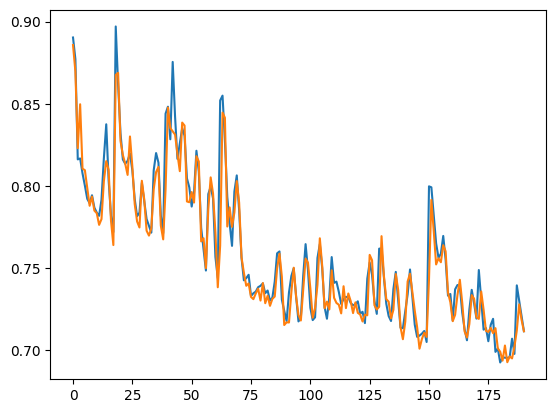

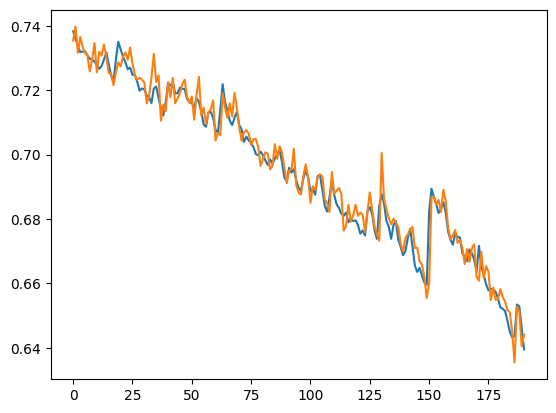

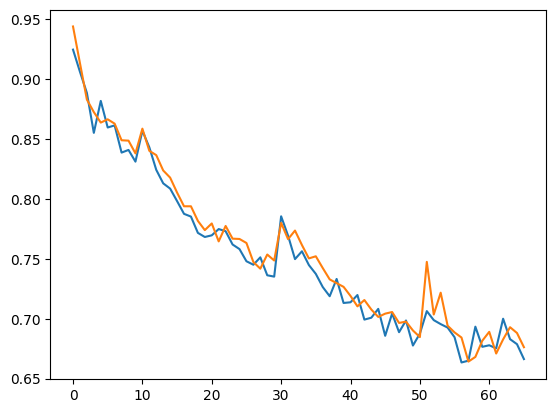

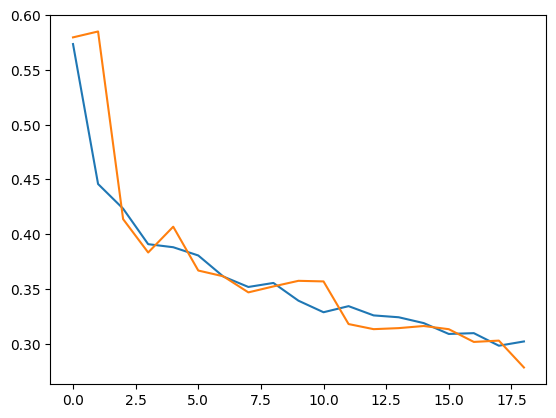

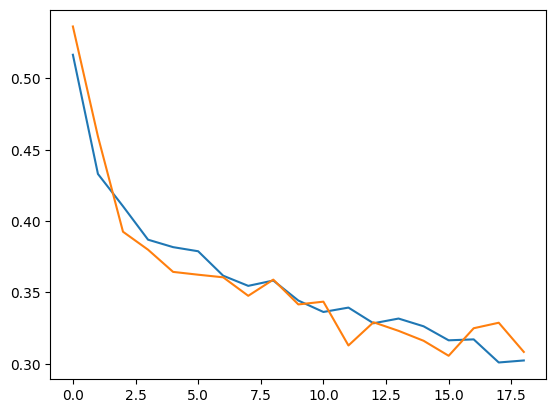

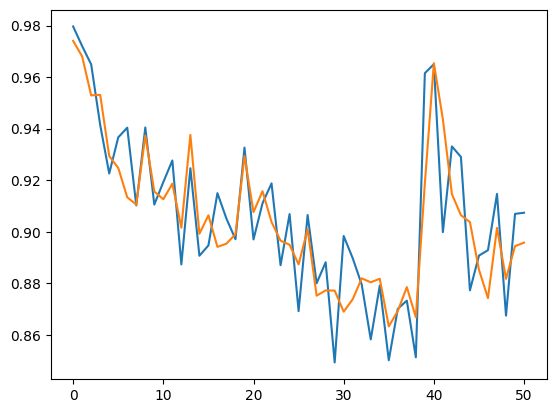

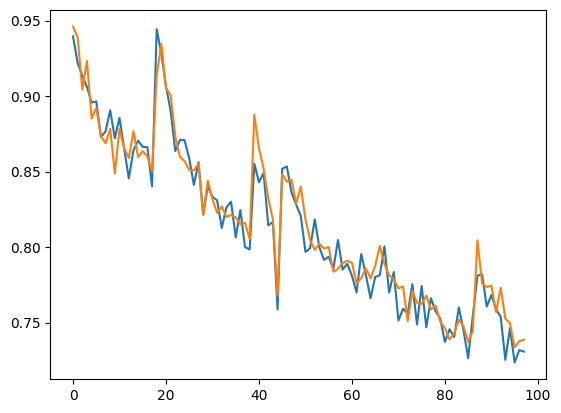

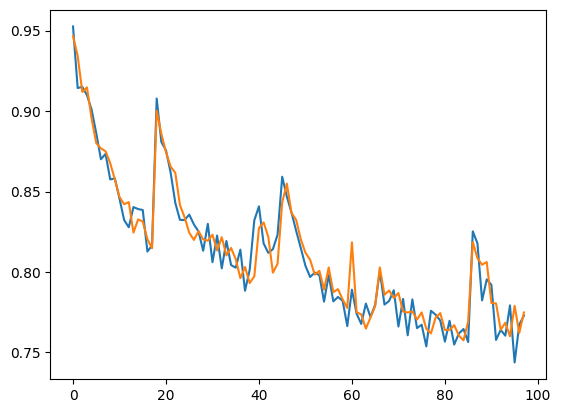

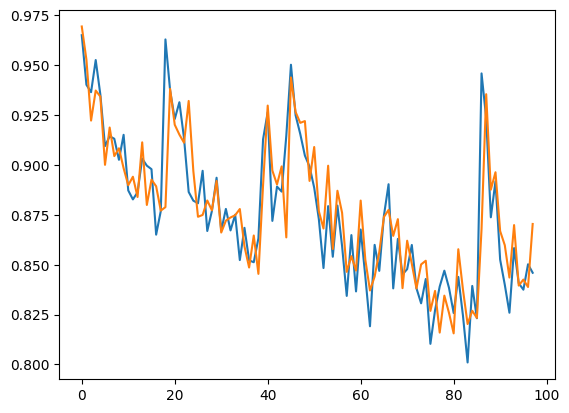

In [ ]:
model = torch.load('trained_model.pt')
def plot_capacity_sequence(model, device, battery_dict, num_cycles):
    for name in battery_dict:
        soh_labels = []
        soh_preds = []
        data, caps = battery_dict[name]['data'], battery_dict[name]['cap']
        for i in range(len(data)-num_cycles):
            input_stream = data[i:i+num_cycles]
            soh_labels.append(caps[i+num_cycles-1])
            input_stream = torch.tensor(input_stream).unsqueeze(0).float().to(device)
            cap_stream = torch.tensor(caps[i:i+num_cycles-1]).unsqueeze(0).float().to(device)
            pred = model(input_stream, cap_stream)
            soh_preds.append(pred.cpu().detach().numpy())
        soh_labels = np.array(soh_labels).ravel()
        soh_preds = np.array(soh_preds).ravel()
        plt.plot(soh_labels)
        plt.plot(soh_preds)
        plt.show()

plot_capacity_sequence(model, device, battery_dict, 3)

# V1 
#### conv 2layer 3-8-16 
#### 0.2 percent of each battery

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm, trange
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model import CNN_Transformer
from dataset import load_NASA

# Load the YAML configuration file
with open('config.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

# # Access the variables
NUM_CYCLES = cfg['NUM_CYCLES']
FEATURE_DIM1 = cfg['FEATURE_DIM1']
FEATURE_DIM2 = cfg['FEATURE_DIM2']
NUM_ATTENTION = cfg['NUM_ATTENTION']
EPOCHS = cfg['EPOCHS']
LEARNING_RATE = cfg['LEARNING_RATE']
BATCH_SIZE = cfg['BATCH_SIZE']

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
train_dataset, test_dataset = load_NASA(folder='NASA_DATA', num_cycles=3, split_ratio=0.3, scale_data=True)

# Train/test split
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# NN model
model = CNN_Transformer(feature_dim1=FEATURE_DIM1, feature_dim2=FEATURE_DIM2, num_attention=NUM_ATTENTION, num_cycles=NUM_CYCLES).to(device)
model = torch.load('trained_model000165.pt', map_location=torch.device('cpu'))

/Users/amir-mac/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/amir-mac/Git-Projects/Battery-SoH-Transformer/dataset.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  battery_data = np.array(battery_data)


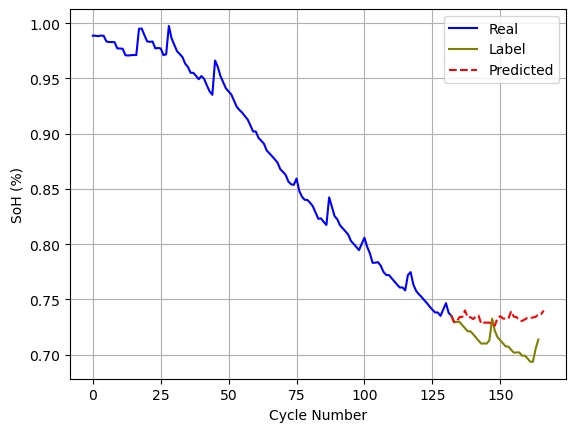

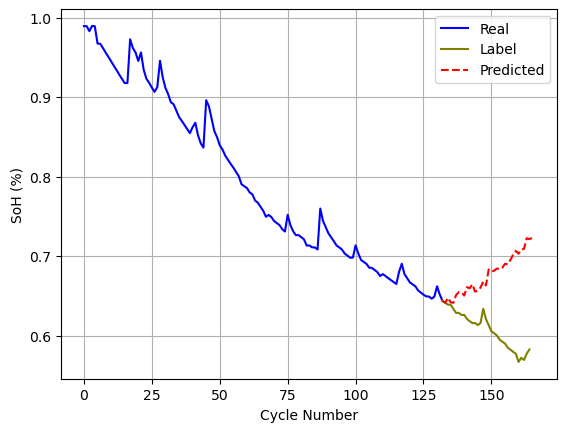

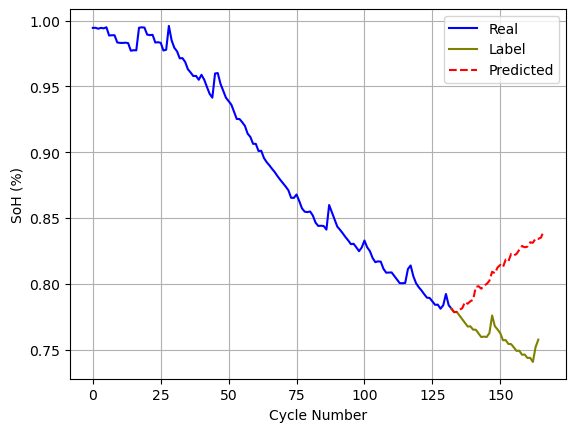

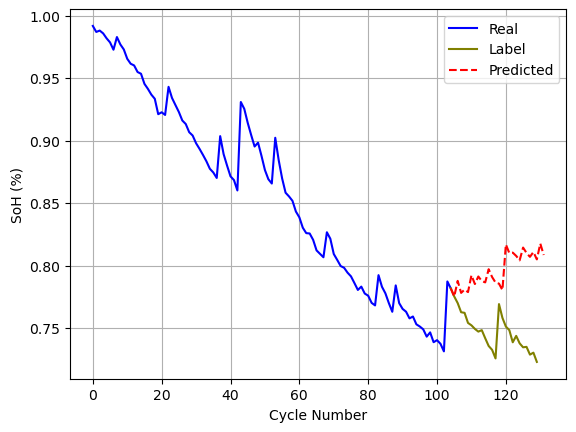

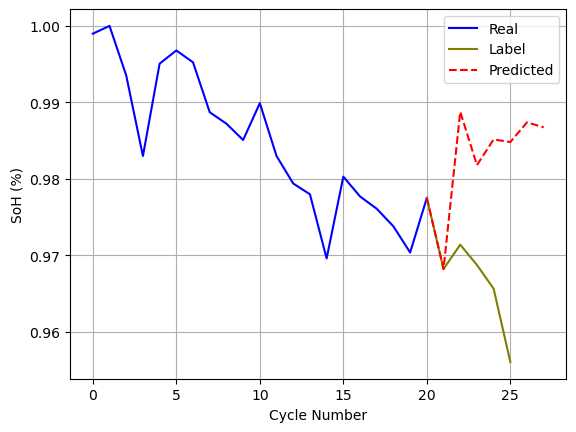

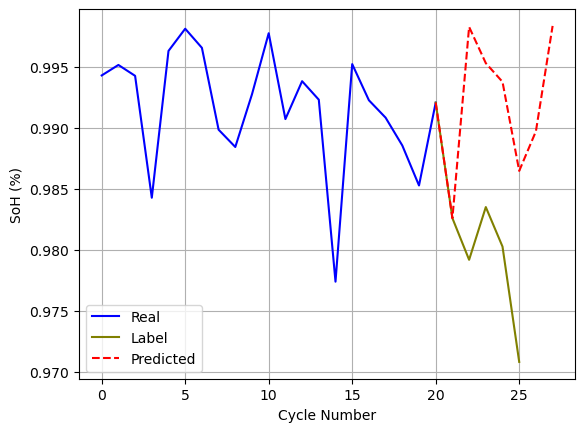

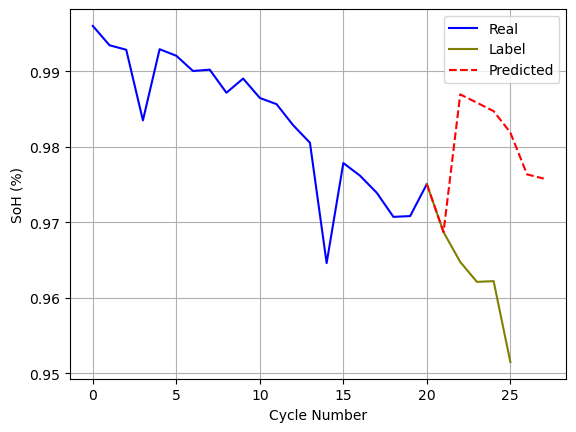

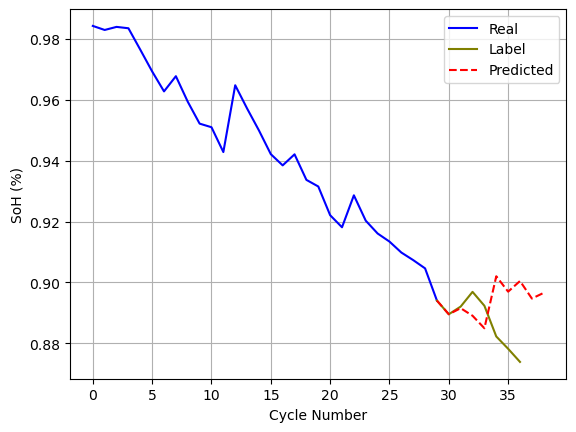

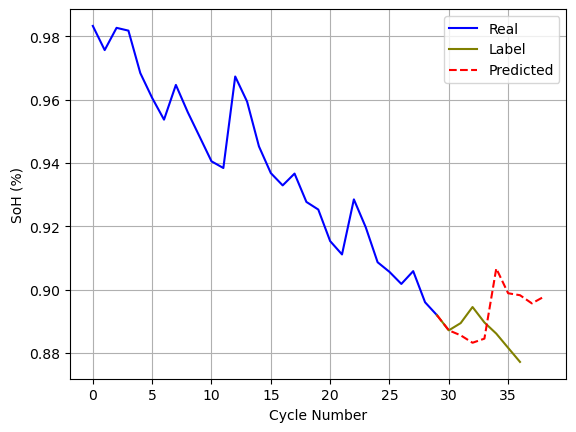

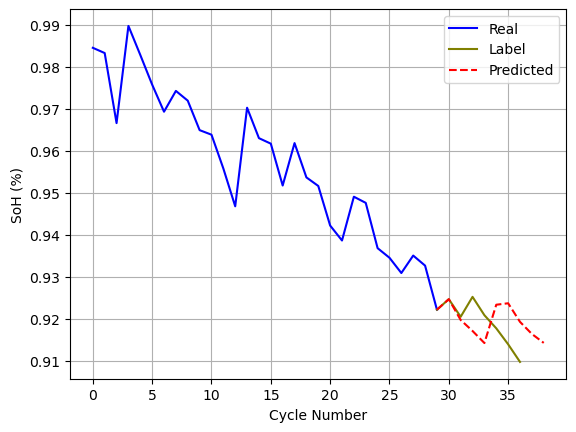

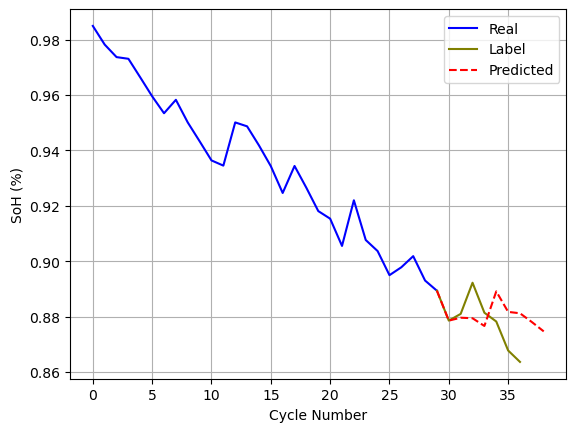

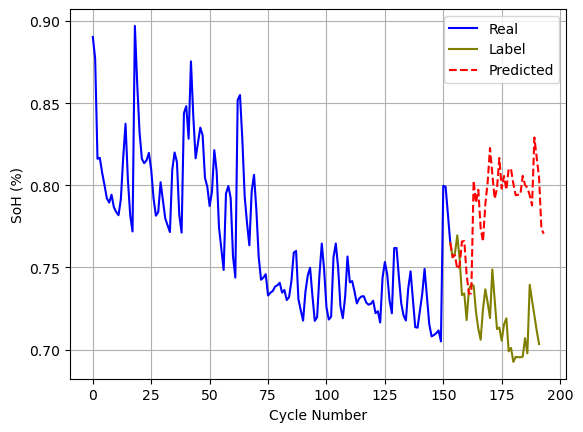

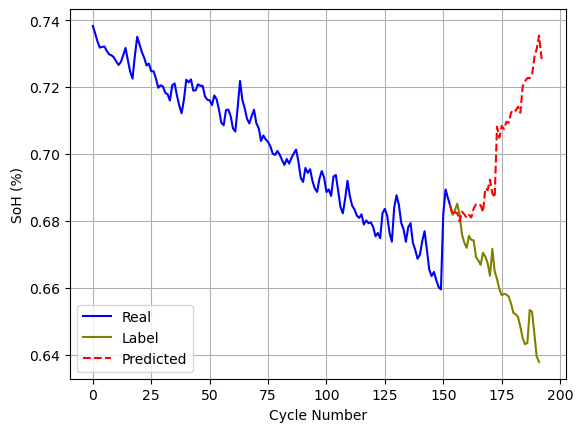

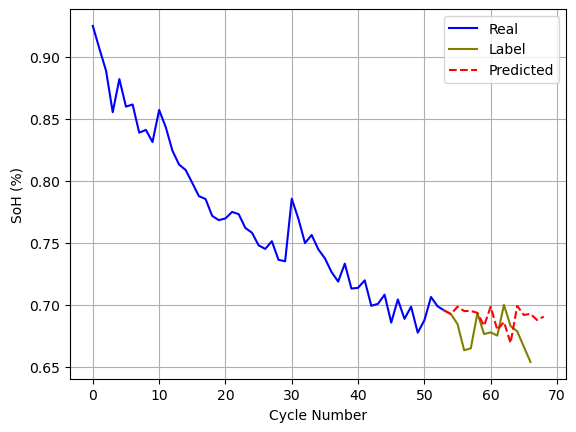

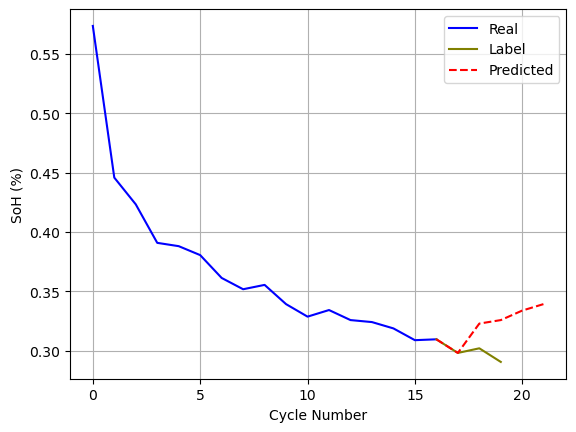

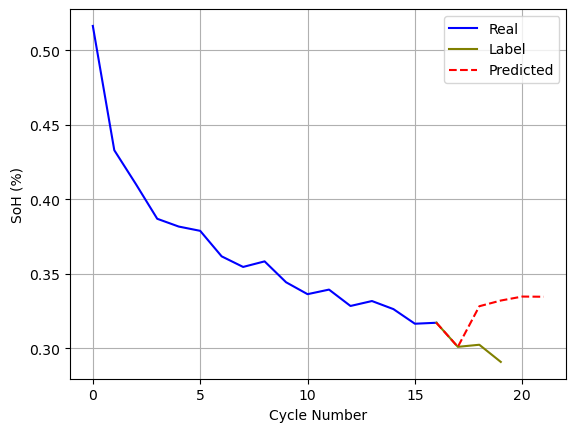

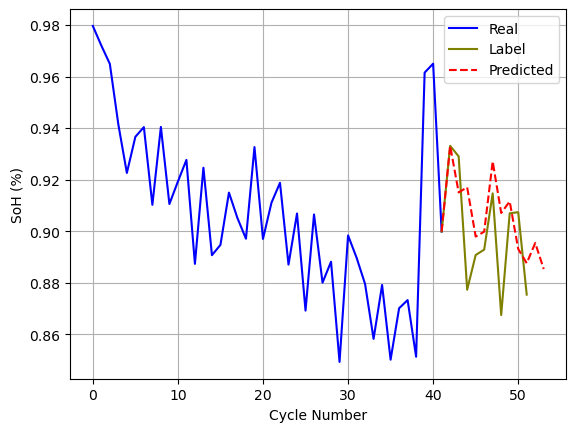

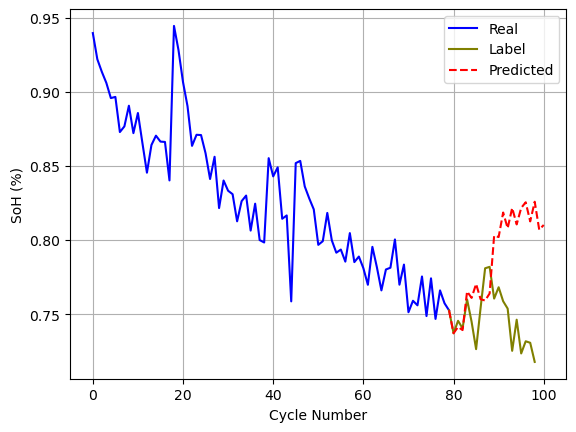

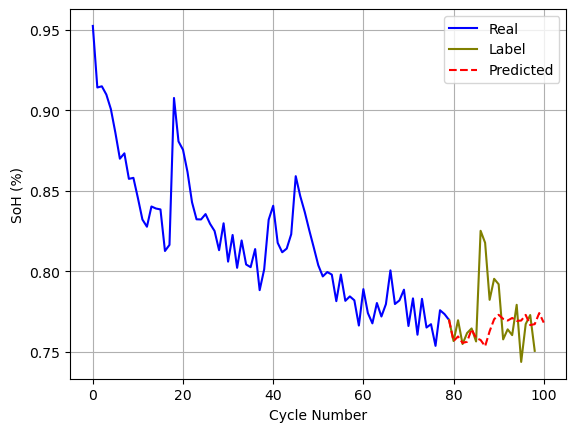

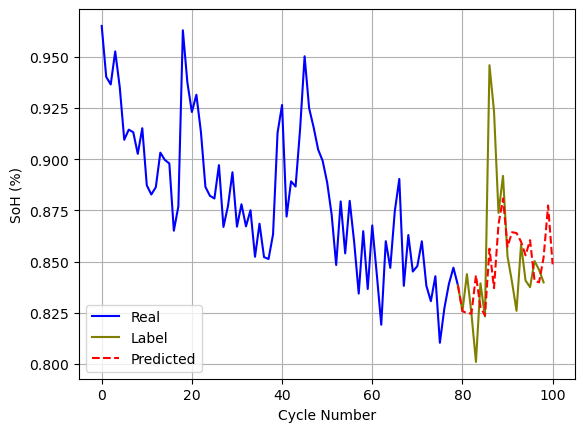

In [3]:
def plot_predicted_capacity(model, train_dataset, test_dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    battery_types = train_dataset.battery_data[:,0]

    for battery_type in np.unique(battery_types):
        train_data = train_dataset.battery_data[train_dataset.battery_data[:,0] == battery_type]
        test_data = test_dataset.battery_data[test_dataset.battery_data[:,0] == battery_type]
        
        train_caps = [c[-1] for c in train_data[:,-1]]
        test_caps = [c[-1] for c in test_data[:,-1]]
        pred_caps = [test_data[:,-1][0][-1], test_data[:,-1][1][-1]]
        for t_data in test_data:
            _, inputs, _ = t_data
            inputs = torch.tensor(inputs).float().unsqueeze(0).to(device)
            outputs = torch.tensor(pred_caps[-2:]).float().unsqueeze(0).to(device)
            # outputs = torch.tensor(outputs).float().unsqueeze(0).to(device)
            pred = model(inputs, outputs)
            pred_caps.append(pred.item())

        plt.plot(train_caps+[test_caps[0]], 'blue')
        plt.plot(range(len(train_caps),len(train_caps)+len(test_caps)), test_caps, c='olive')
        plt.plot(range(len(train_caps),len(train_caps)+len(pred_caps)), pred_caps, '--', c='red')
        plt.grid('on')
        plt.legend(['Real','Label','Predicted'])
        plt.xlabel('Cycle Number')
        plt.ylabel('SoH (%)')
        plt.show()

plot_predicted_capacity(model, train_dataset, test_dataset)

### pred sequence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm, trange
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model import CNN_Transformer
from dataset import load_NASA

# Load the YAML configuration file
with open('config.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

# # Access the variables
NUM_CYCLES = cfg['NUM_CYCLES']
NUM_PREDS = cfg['NUM_PREDS']
FEATURE_DIM1 = cfg['FEATURE_DIM1']
FEATURE_DIM2 = cfg['FEATURE_DIM2']
NUM_ATTENTION = cfg['NUM_ATTENTION']
EPOCHS = cfg['EPOCHS']
LEARNING_RATE = cfg['LEARNING_RATE']
BATCH_SIZE = cfg['BATCH_SIZE']

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
train_dataset, test_dataset = load_NASA(folder='NASA_DATA', num_cycles=NUM_CYCLES+NUM_PREDS-1, split_ratio=0.3, scale_data=True)

# Train/test split
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# NN model
model = CNN_Transformer(feature_dim1=FEATURE_DIM1, 
                        feature_dim2=FEATURE_DIM2, 
                        num_attention=NUM_ATTENTION, 
                        num_cycles=NUM_CYCLES, 
                        num_preds=NUM_PREDS).to(device)

/Users/amir-mac/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/amir-mac/Git-Projects/Battery-SoH-Transformer/dataset.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  battery_data = np.array(battery_data)


In [2]:
for epoch in range(1):
    for inputs, outputs in train_dataloader:
        inputs = inputs.float()
        outputs = outputs.float()
        break

In [3]:
inputs.shape, outputs.shape

(torch.Size([64, 9, 256, 3]), torch.Size([64, 9]))

In [4]:
model.pred_sequence(inputs,outputs).shape

torch.Size([64, 9])

In [9]:
pred_caps = torch.stack([outputs[:,0], outputs[:,1]], axis=-1)
pred_caps.shape

torch.Size([64, 2])

In [10]:
inputs[:,cycle:cycle+num_cycles].shape

NameError: name 'cycle' is not defined

In [11]:
cycle = 0
num_cycles = 3
pred = model(inputs[:,cycle:cycle+num_cycles], pred_caps[:,-num_cycles+1:])

In [12]:
pred.shape

torch.Size([64, 1])

In [13]:
torch.cat([pred_caps, pred], axis=-1).shape


torch.Size([64, 3])

In [6]:
my_data = inputs
capacity = outputs

pred_caps = torch.stack([capacity[:,0], capacity[:,1]], axis=-1)
for cycle in range(model.num_preds):
    pred = model.forward(my_data[:,cycle:cycle+model.num_cycles], pred_caps[:,-model.num_cycles+1:])
    pred_caps = torch.cat([pred_caps, pred], axis=-1)
